In [14]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

import matplotlib.pyplot as plt
from lib.plotting import adjust_plot_1d

In [15]:
bp = '/home/storage/hans/jax_reco_new/examples/compare_methods/'

SPE_post_conv = np.load(bp+'reco_result_21217_21220_sigma_3.0_SPE_c_multi_gamma_spe_prob_v.npy')
SPE_conv = np.load(bp+'reco_result_21217_21220_sigma_3.0_SPE_cgamma_c_multi_gamma_prob.npy')
MPE_post_conv = np.load(bp+'reco_result_21217_21220_sigma_3.0_clipcharge20_c_multi_gamma_mpe_prob_midpoint_v.npy')
#MPE_post_conv_and_noise = np.load(bp+'reco_result_21217_21220_sigma_3.0_clipcharge20_c_multi_gamma_mpe_prob_midpoint_v_AND_noise.npy')
#MPE_post_conv_and_noise = np.load(bp+'reco_result_21217_21220_sigma_3.0_clipcharge100_c_multi_gamma_mpe_prob_midpoint2_v_AND_noise.npy')
MPE_post_conv_and_noise = np.load(bp+'reco_result_21217_21220_sigma_3.0_clipcharge200_c_multi_gamma_mpe_prob_combine_v_AND_noise.npy')
MPE_pre_conv = np.load(bp+'reco_result_21217_21220_sigma_3.0_MPE_cgamma_c_multi_gamma_prob_and_sf.npy')
MPE_pre_conv_clip = np.load(bp+'reco_result_21217_21220_sigma_3.0_MPE_clipcharge_30_cgamma_c_multi_gamma_prob_and_sf.npy')
MPE_pre_conv_biweight = np.load(bp+'reco_result_21217_21220_sigma_3.0_MPE_c_multi_gamma_biweight_mpe_logprob.npy')
MPE_pre_conv_biweight_clip = np.load(bp+'reco_result_21217_21220_sigma_3.0_MPE_clip_charge_at_30_c_multi_gamma_biweight_mpe_logprob.npy')
MPE_pre_conv_biweight_postjitter = np.load(bp+'reco_result_21217_21220_sigma_3.0_MPE_c_multi_gamma_biweight_mpe_logprob_postjitter.npy')

In [16]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [17]:
def get_gcd(results):
    scale = 20.0
    reco_zenith, reco_azimuth = results[:, 14]/scale, results[:, 15]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

In [18]:
def get_deltalogl(results):
    muon_energy = results[:, 0]
    delta_logl = results[:, -1]
    return muon_energy, delta_logl

In [19]:
def get_resolution(results):
    gcd, gcd_smpe, muon_energy = get_gcd(results)
       
    def get_quantiles(dpsi, energy, e_bins):
        lower, med, upper = [], [], []
        for el, eh in zip(e_bins[:-1], e_bins[1:]):
            #print(el, eh)
            idx = np.logical_and(energy >= el, energy < eh)
            l, m, u = np.percentile(dpsi[idx], [20, 50, 80])
            lower.append(l)
            med.append(m)
            upper.append(u)
        
        return lower, med, upper

    e_nu_range = [2.0, 6.0]
    e_nu_bins = np.linspace(*e_nu_range, 21)
    centers = lambda x: 0.5 * (x[:-1]+x[1:])
    e_nu_centers = centers(e_nu_bins)
    lower, med, upper = get_quantiles(gcd, np.log10(muon_energy), e_nu_bins)
    lower2, med2, upper2 = get_quantiles(gcd_smpe, np.log10(muon_energy), e_nu_bins)

    return (lower, med, upper), (lower2, med2, upper2), e_nu_centers

In [20]:
r_SPE_conv, r_smpe, xvals = get_resolution(SPE_conv)
r_SPE_post_conv, r_smpe, xvals = get_resolution(SPE_post_conv)
r_MPE_post_conv, r_smpe, xvals = get_resolution(MPE_post_conv)
r_MPE_post_conv_and_noise, r_smpe, xvals = get_resolution(MPE_post_conv_and_noise)
r_MPE_pre_conv, r_smpe, xvals = get_resolution(MPE_pre_conv)
r_MPE_pre_conv_clip, r_smpe, xvals = get_resolution(MPE_pre_conv_clip)
r_MPE_pre_conv_biweight, r_smpe, xvals = get_resolution(MPE_pre_conv_biweight)
r_MPE_pre_conv_biweight_clip, r_smpe, xvals = get_resolution(MPE_pre_conv_biweight_clip)
r_MPE_pre_conv_biweight_postjitter, r_smpe, xvals = get_resolution(MPE_pre_conv_biweight_postjitter)

In [21]:
print(MPE_post_conv_and_noise[:, 14]/20)
print(MPE_post_conv_and_noise[:, 2])

[1.61642281 1.72991437 2.34679367 ... 1.70333121 1.78898893 1.59357587]
[1.6027203  1.74182769 2.35293338 ... 1.69937182 1.78040836 1.59483812]


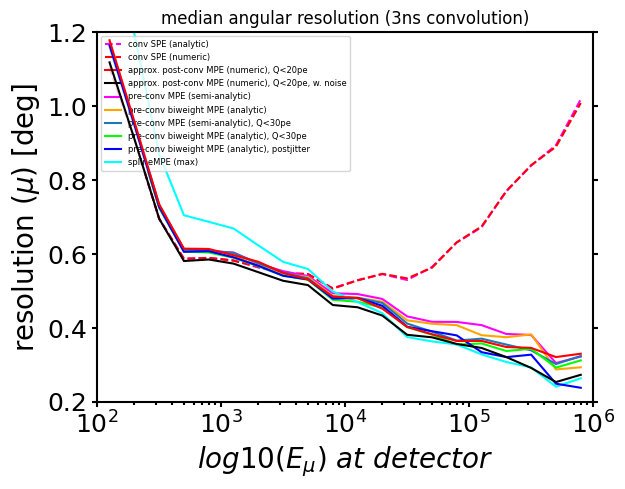

In [22]:
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.2, 1.2]}

ax.plot(10**xvals, r_SPE_conv[1], color='magenta', label='conv SPE (analytic)', linestyle='dashed')
ax.plot(10**xvals, r_SPE_post_conv[1], color='red', label='conv SPE (numeric)', linestyle='dashed')
ax.plot(10**xvals, r_MPE_post_conv[1], color='red', label='approx. post-conv MPE (numeric), Q<20pe', linestyle='solid', zorder=17)
ax.plot(10**xvals, r_MPE_post_conv_and_noise[1], color='black', label='approx. post-conv MPE (numeric), Q<20pe, w. noise', linestyle='solid', zorder=17)
#ax.plot(10**xvals, r_MPE_post_conv[2], color='red', linestyle='dotted', zorder=15)
ax.plot(10**xvals, r_MPE_pre_conv[1], color='magenta', label='pre-conv MPE (semi-analytic)', linestyle='solid')
ax.plot(10**xvals, r_MPE_pre_conv_biweight[1], color='orange', label='pre-conv biweight MPE (analytic)', linestyle='solid')
ax.plot(10**xvals, r_MPE_pre_conv_clip[1], color='tab:blue', label='pre-conv MPE (semi-analytic), Q<30pe', linestyle='solid')
ax.plot(10**xvals, r_MPE_pre_conv_biweight_clip[1], color='lime', label='pre-conv biweight MPE (analytic), Q<30pe', linestyle='solid')
ax.plot(10**xvals, r_MPE_pre_conv_biweight_postjitter[1], color='blue', label='pre-conv biweight MPE (analytic), postjitter', 
        linestyle='solid', zorder=16)
#ax.plot(10**xvals, r_MPE_pre_conv_biweight_postjitter[2], color='black', zorder=16, linestyle='dotted')
ax.plot(10**xvals, r_smpe[1], color='cyan', label='splineMPE (max)')
#ax.plot(10**xvals, r_smpe[2], color='cyan', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.xscale('log')
plt.title('median angular resolution (3ns convolution)')
ax.set_yticks([0.2*i for i in range(9)][1:-2])
plt.legend(fontsize=6, loc='upper left')
plt.show()

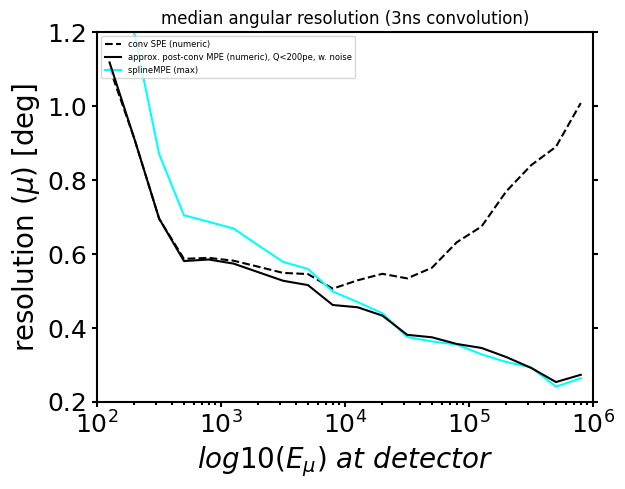

In [23]:
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.2, 1.2]}

#ax.plot(10**xvals, r_SPE_conv[1], color='magenta', label='conv SPE (analytic)', linestyle='dashed')
ax.plot(10**xvals, r_SPE_post_conv[1], color='black', label='conv SPE (numeric)', linestyle='dashed')
#ax.plot(10**xvals, r_MPE_post_conv[1], color='red', label='approx. post-conv MPE (numeric), Q<20pe', linestyle='solid', zorder=17)
ax.plot(10**xvals, r_MPE_post_conv_and_noise[1], color='black', label='approx. post-conv MPE (numeric), Q<200pe, w. noise', linestyle='solid', zorder=17)
#ax.plot(10**xvals, r_MPE_post_conv[2], color='red', linestyle='dotted', zorder=15)
#ax.plot(10**xvals, r_MPE_pre_conv[1], color='magenta', label='pre-conv MPE (semi-analytic)', linestyle='solid')
#ax.plot(10**xvals, r_MPE_pre_conv_biweight[1], color='orange', label='pre-conv biweight MPE (analytic)', linestyle='solid')
#ax.plot(10**xvals, r_MPE_pre_conv_clip[1], color='tab:blue', label='pre-conv MPE (semi-analytic), Q<30pe', linestyle='solid')
#ax.plot(10**xvals, r_MPE_pre_conv_biweight_clip[1], color='lime', label='pre-conv biweight MPE (analytic), Q<30pe', linestyle='solid')
#ax.plot(10**xvals, r_MPE_pre_conv_biweight_postjitter[1], color='blue', label='pre-conv biweight MPE (analytic), postjitter', 
#        linestyle='solid', zorder=16)
#ax.plot(10**xvals, r_MPE_pre_conv_biweight_postjitter[2], color='black', zorder=16, linestyle='dotted')
ax.plot(10**xvals, r_smpe[1], color='cyan', label='splineMPE (max)')
#ax.plot(10**xvals, r_smpe[2], color='cyan', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.xscale('log')
plt.title('median angular resolution (3ns convolution)')
ax.set_yticks([0.2*i for i in range(9)][1:-2])
plt.legend(fontsize=6, loc='upper left')
plt.show()

In [11]:
def get_hist(results, emin, emax):
    gcd, gcd_smpe, muon_energy = get_gcd(results)
    idx = np.logical_and(muon_energy > emin, muon_energy < emax)
    bins = np.linspace(0.0, 3.0, 41)
    cts, _ = np.histogram(gcd[idx], bins=bins)
    cts_smpe, _ = np.histogram(gcd_smpe[idx], bins=bins)
    return cts, bins, cts_smpe


In [12]:
def make_hist_plot(emin, emax):
    cts_MPE_post_conv, bins, cts_smpe = get_hist(MPE_post_conv, emin, emax)
    cts_SPE_post_conv, bins, cts_smpe = get_hist(SPE_post_conv, emin, emax)
    cts_MPE_pre_conv_biweight_postjitter, bins, cts_smpe = get_hist(MPE_pre_conv_biweight_postjitter, emin, emax)

    plot_args = {'xlabel':'angular separation [deg]', 
                 'ylabel':'NEvents', 
                 'xlim':[0.0, 3.0], 
                 'ylim':[0.0, np.amax([cts_smpe, cts_MPE_post_conv, cts_SPE_post_conv, cts_MPE_pre_conv_biweight_postjitter])*1.1]}
    
    fig, ax = plt.subplots()
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_SPE_post_conv, histtype='step', 
             label='conv SPE (numeric)', color='red', linestyle='dashed')
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_MPE_post_conv, histtype='step', 
             label='approx. post-conv MPE (numeric), Q<20pe', color='red')
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_MPE_pre_conv_biweight_postjitter, histtype='step', 
             label='pre-conv biweight MPE (analytic), postjitter', color='black')
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts_smpe, histtype='step', 
             label='splineMPE (max)', color='cyan')
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.title(f"muon energy: {emin/1000}TeV to {emax/1000}TeV")
    plt.show()

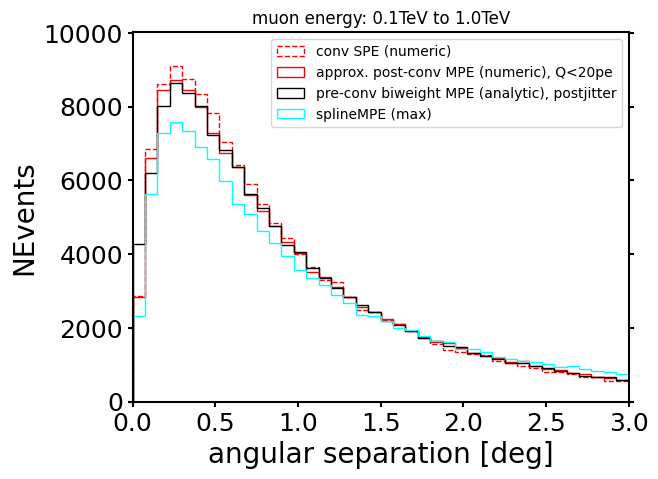

In [13]:
make_hist_plot(100, 1000)

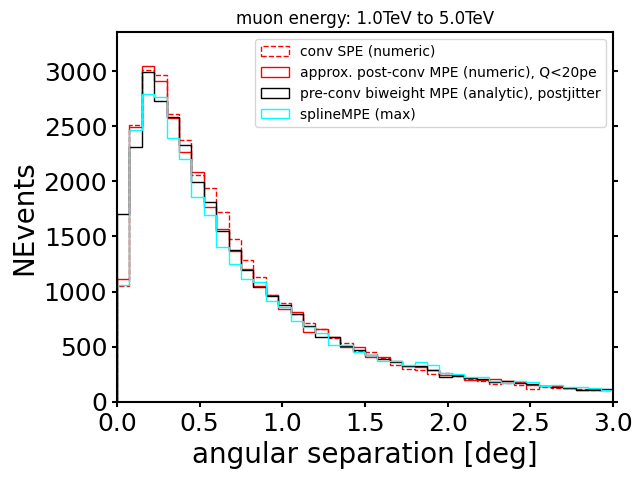

In [27]:
make_hist_plot(1000, 5000)

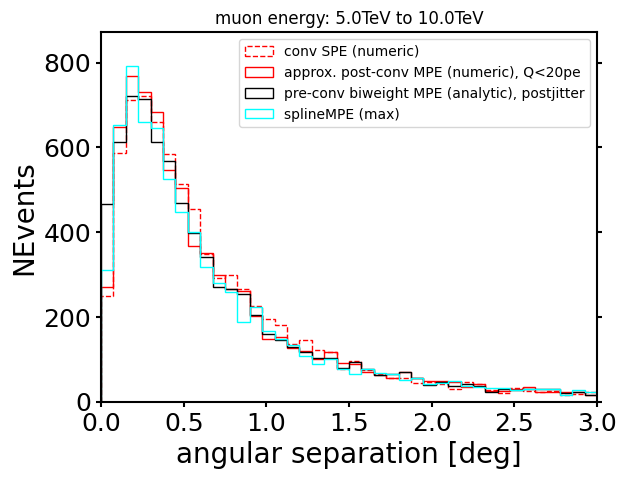

In [28]:
make_hist_plot(5000, 10000)

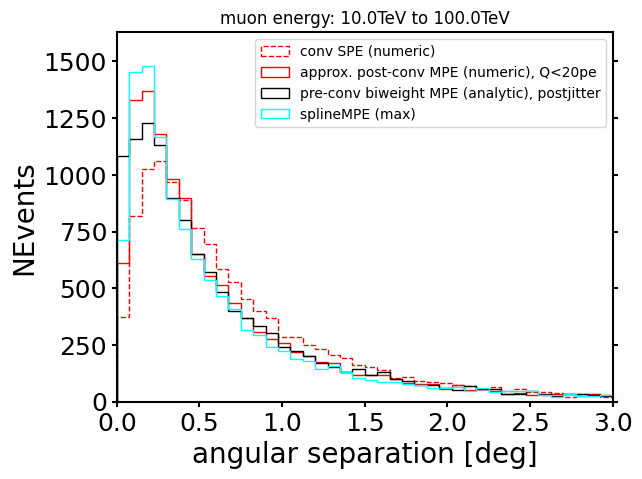

In [29]:
make_hist_plot(10000, 100000)

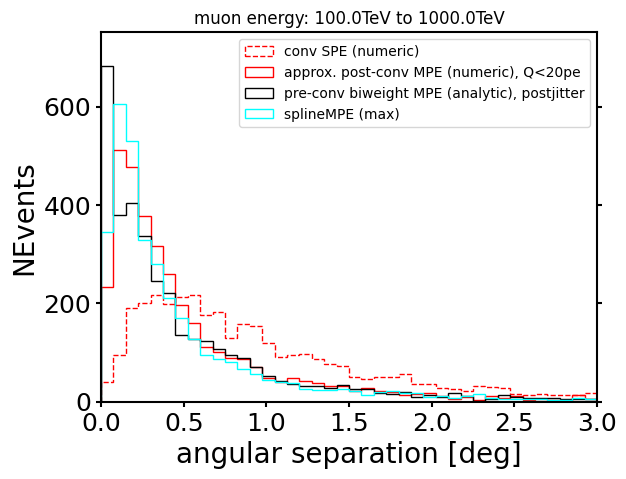

In [30]:
make_hist_plot(100000, 1000000)

In [33]:
muon_energy, delta_logl = get_deltalogl(MPE_pre_conv_biweight_postjitter)

In [34]:
np.percentile(delta_logl, [68, 90])

array([nan, nan])

In [35]:
from scipy.stats import chi2

In [36]:
chi2.cdf(14, 5)

0.9843905838997331

In [40]:
def make_hist_plot_logl(results, emin, emax, nbins = 156, xmax=150):
    def get_hist(results, emin, emax):
        muon_energy, delta_logl = get_deltalogl(results)
        idx = np.logical_and(muon_energy > emin, muon_energy < emax)
        bins = np.linspace(-5.0, 150.0, nbins)
        cts, _ = np.histogram(delta_logl[idx], bins=bins)
        return cts, bins
    
    cts, bins = get_hist(results, emin, emax)

    plot_args = {'xlabel':'-2$\Delta$logL', 
                 'ylabel':'NEvents', 
                 'xlim':[-2.0, xmax], 
                 'ylim':[0.0, 1.2*np.amax(cts)]}
    
    fig, ax = plt.subplots()
    plt.hist(0.5*(bins[1:]+bins[:-1]), bins=bins, weights=cts, histtype='step', 
             label='TPN MPE', color='red')
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.title(f"muon energy: {emin/1000}TeV to {emax/1000}TeV")
    plt.yscale('log')
    plt.ylim(ymin=1.e-1)
    plt.show()

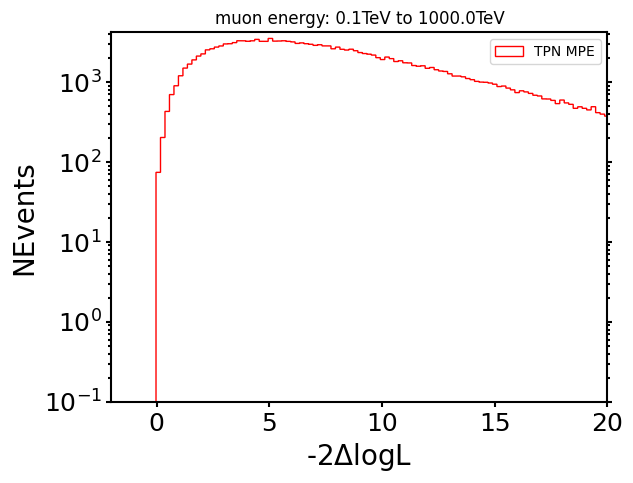

In [41]:
make_hist_plot_logl(MPE_pre_conv_biweight_postjitter, 100, 1000000, nbins=156*5, xmax=20)

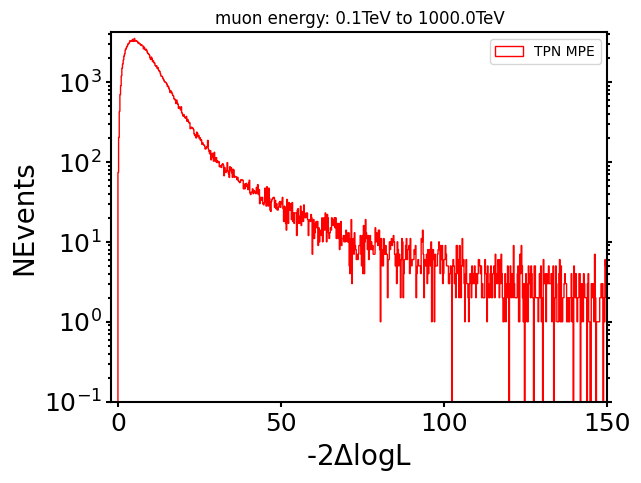

In [42]:
make_hist_plot_logl(MPE_pre_conv_biweight_postjitter, 100, 1000000, nbins=156*5)

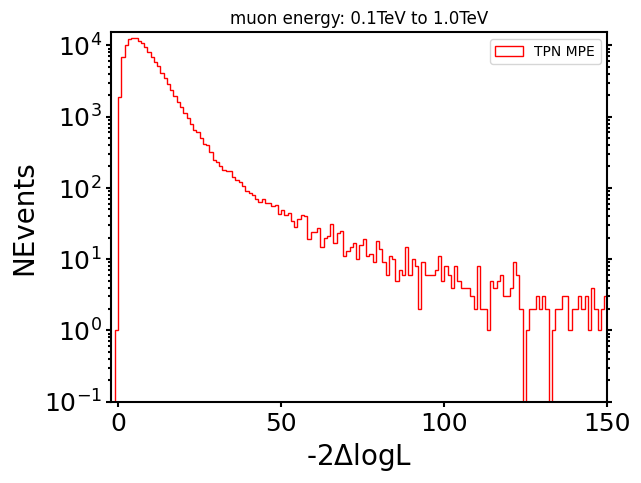

In [43]:
make_hist_plot_logl(MPE_pre_conv_biweight_postjitter, 100, 1000)

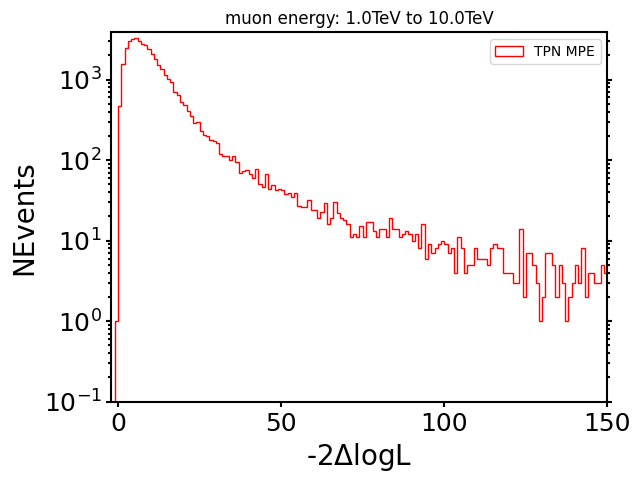

In [44]:
make_hist_plot_logl(MPE_pre_conv_biweight_postjitter, 1000, 10000)

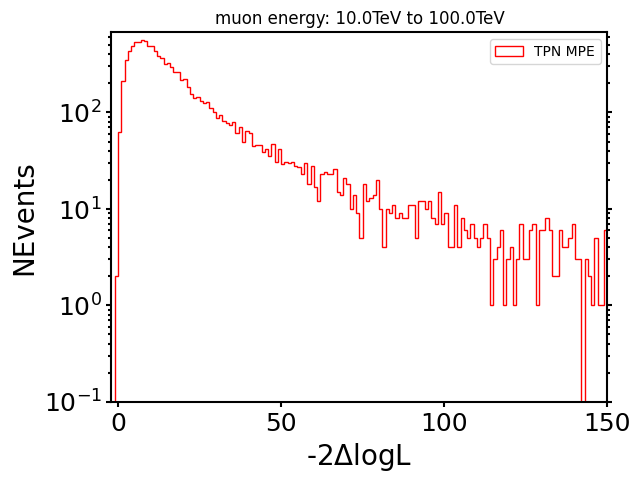

In [45]:
make_hist_plot_logl(MPE_pre_conv_biweight_postjitter, 10000, 100000)

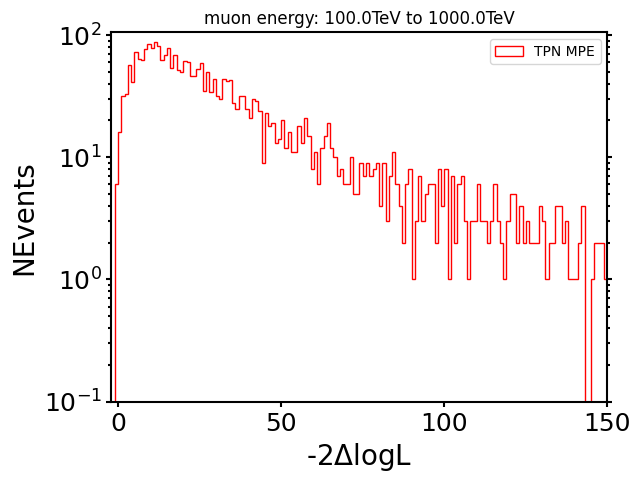

In [46]:
make_hist_plot_logl(MPE_pre_conv_biweight_postjitter, 100000, 1000000)

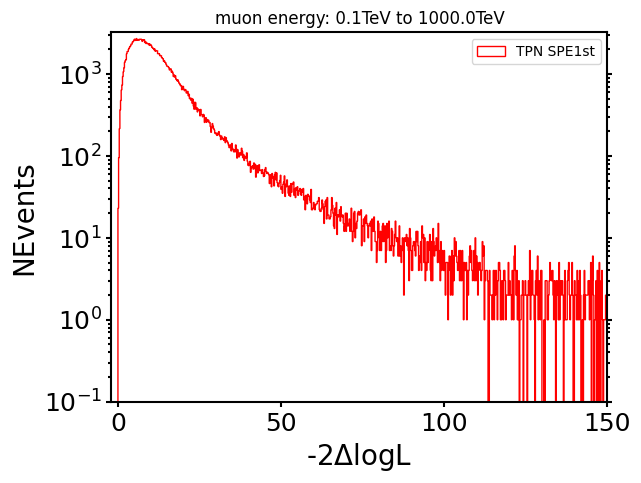

In [33]:
make_hist_plot_logl(SPE_sigma2_rho, 100, 1000000, nbins=156*5)

In [17]:
import jax
import jax.numpy as jnp

@jax.jit
def f(x, y):
    return jnp.sum(x) + jnp.sum(y)

f_vmap = jax.jit(jax.vmap(f, (0, 0), 0))

In [15]:
x0 = jnp.ones(10) * 0.5
y0 = jnp.ones(20) * (-0.5)

In [16]:
print(f(x0, y0))

-5.0


In [18]:
x0 = jnp.ones((10, 10)) * 0.5
y0 = jnp.ones((20, 20)) * (-0.5)

In [19]:
print(f_vmap(x0, y0))

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * one axis had size 10: axis 0 of argument x of type float32[10,10];
  * one axis had size 20: axis 0 of argument y of type float32[20,20]

In [20]:
print(f(x0, y0))

-150.0


In [11]:
_, d = get_deltalogl(MPE_pre_conv_biweight_postjitter)

In [14]:
print(len(d), len(d[np.isfinite(d)]))

202092 198484


In [19]:
_, d = get_deltalogl(MPE_pre_conv_biweight_clip)

In [20]:
print(len(d), len(d[np.isfinite(d)]))

202092 200723


In [21]:
_, d = get_deltalogl(MPE_pre_conv_biweight)

In [22]:
print(len(d), len(d[np.isfinite(d)]))

202092 200717


In [24]:
_, d = get_deltalogl(MPE_post_conv_and_noise)

In [25]:
print(len(d), len(d[np.isfinite(d)]))

202092 202092
